# ATMS 523

## Module 4 Project

Submit this code as a pull request back to GitHub Classroom by the date and time listed in Canvas.

For this assignment, use the ERA-5 *monthly mean* data from Copernicus Data Service.  

1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download]
(https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)

In [ ]:
# 2)From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data.

import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from eofs.xarray import Eof
from eofs.examples import example_data_path


In [ ]:
#Load the data
ds = xr.open_dataset('C:/Users/jclabarcena/Documents/ATM523/ATMS-523-Module-4/data/47ff57cebd30f4fe1f8084dca7728daf/data_stream-moda_stepType-avgua.nc')

In [28]:
print(ds)

<xarray.Dataset> Size: 5GB
Dimensions:     (valid_time: 1020, latitude: 521, longitude: 721)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 16kB ...
Data variables:
    sst         (valid_time, latitude, longitude) float32 2GB ...
    lsm         (valid_time, latitude, longitude) float32 2GB ...
    tcwv        (valid_time, latitude, longitude) float32 2GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-10-26T21:14 GRIB to CDM+CF via cfgrib-0.9.1...


In [29]:
ds['valid_time'].head

<bound method DataArray.head of <xarray.DataArray 'valid_time' (valid_time: 1020)> Size: 8kB
array(['1940-01-01T00:00:00.000000000', '1940-02-01T00:00:00.000000000',
       '1940-03-01T00:00:00.000000000', ..., '2024-10-01T00:00:00.000000000',
       '2024-11-01T00:00:00.000000000', '2024-12-01T00:00:00.000000000'],
      shape=(1020,), dtype='datetime64[ns]')
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
    expver      (valid_time) <U4 16kB ...
Attributes:
    long_name:      time
    standard_name:  time>

In [30]:
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    # numeric seconds since first timestamp (keeps numbers small)
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    """
    Remove a linear trend y ~ s*(t - t̄_valid) + ȳ_valid at each grid point.
    Closed-form LS using reductions; dask-friendly; handles NaNs.
    """
    t = _time_as_float(obj[time_dim], time_dim)  # (time,)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})  # one chunk along time
        mask = da.notnull()                                # (time, ...)
        t_b = t.broadcast_like(da)                         # (time, ...)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid                            # centered time per point
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar  = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    """
    From linearly-detrended data, remove monthly climatology and compute monthly z-scores.
    Returns (anom, z). Works for Dataset or DataArray.
    """
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"

    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean

    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z


In [31]:
# Example:
# ds is a monthly ERA5 Dataset or DataArray with dimension "time"
# If Dataset, all variables get processed; if DataArray, just that variable
# ds = ds.chunk({"time": -1})  # optional: ensure time is a single chunk for speed
# Optional: keep time in one chunk for speed
ds = ds.chunk({"valid_time": -1})

detr = linear_detrend(ds[["sst", "tcwv"]], time_dim="valid_time")   # or just ds if you want all float vars
anom, z = monthly_anom_and_z(detr, time_dim="valid_time",
                             base_period=("1981-01-01", "2010-12-31"))  # or None for full-period

print(type(z), list(z.data_vars))   # should show a Dataset with ['sst','tcrw']


<class 'xarray.core.dataset.Dataset'> ['sst', 'tcwv']


In [32]:
print(anom['sst'])

<xarray.DataArray 'sst' (valid_time: 1020, latitude: 521, longitude: 721)> Size: 2GB
dask.array<sub, shape=(1020, 521, 721), dtype=float32, chunksize=(1, 521, 721), chunktype=numpy.ndarray>
Coordinates:
    number      (valid_time) int64 8kB 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
  * valid_time  (valid_time) datetime64[ns] 8kB 1940-01-01 ... 2024-12-01
  * latitude    (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude   (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    expver      (valid_time) <U4 16kB '0001' '0001' '0001' ... '0001' '0001'
    month       (valid_time) int64 8kB 1 2 3 4 5 6 7 8 9 ... 5 6 7 8 9 10 11 12


In [ ]:

#Then, standardize the SST anomalies.  Standardization means subtract the long term mean and divide by the standard deviation, which can be accomplished using the methods described here: [6.3. Preprocessing data &mdash; scikit-learn 1.1.2 documentation](https://scikit-learn.org/stable/modules/preprocessing.html)

from sklearn.preprocessing import StandardScaler
data = anom['sst'].values.reshape(-1, 1)  #reshaping to be a 2D array with one column
scaler = StandardScaler()
values_scaler = scaler.fit(data)
sst_stand = scaler.fit_transform(data)


c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\dask\_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
c:\Users\jclabarcena\AppData\Local\anaco

In [37]:
#Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.
# 2) create a temporary copy with time dim named 'time' for EOF analysis
sst_for_eof = anom['sst'].rename({"valid_time": "time"})

# Rechunk to reduce memory usage: one chunk in time, smaller in lat/lon
sst_for_eof_chunked = sst_for_eof.chunk({'time': -1, 'latitude': 30, 'longitude': 30})

In [38]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of latitude weights are applied before the computation of EOFs.
coslat = np.cos(np.deg2rad(sst_for_eof_chunked.coords['latitude'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_for_eof_chunked, weights=wgts)

c:\Users\jclabarcena\AppData\Local\anaconda3\envs\xarray-climate\Lib\site-packages\dask\array\slicing.py:1028: PerformanceWarning: Increasing number of chunks by factor of 521
  p = blockwise(


In [39]:
# Retrieve the first 5 EOF, expressed as the correlation between the leading PC time series and the input SST anomalies at each grid point, and the leading PC time series itself.

eof5 = solver.eofsAsCorrelation(neofs=5)
pc1 = solver.pcs(npcs=5, pcscaling=1)


C:\Users\jclabarcena\AppData\Local\Temp\ipykernel_34468\46847650.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.10, 1, 1])


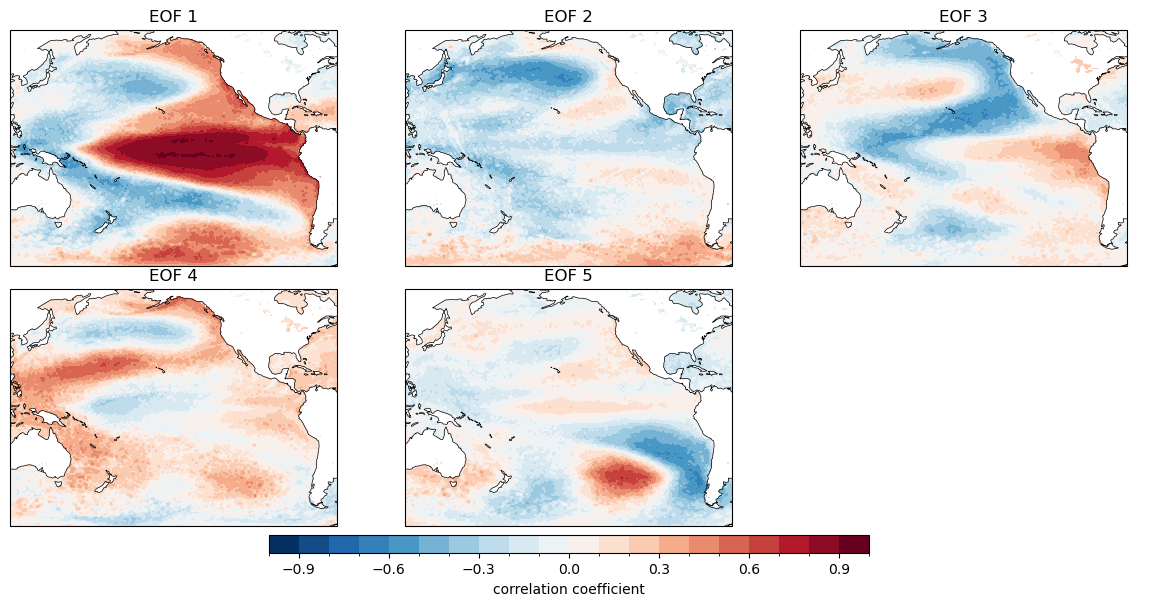

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# eof1 is your correlation maps (mode x lat x lon)
neofs = 5
ncols = 3
nrows = int(np.ceil(neofs / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows),
                         subplot_kw={"projection": ccrs.PlateCarree(central_longitude=190)})
axes = axes.ravel()

clevs = np.linspace(-1, 1, 21)  # correlation range
for i in range(neofs):
    ax = axes[i]
    eof_map = eof5.isel(mode=i)
    cf = eof_map.plot.contourf(ax=ax, levels=clevs, cmap="RdBu_r",
                               add_colorbar=False, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    # Pacific Basin extent: 120°E -> 60°W expressed as 120 -> 300 (0-360 lon)
    ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
    ax.set_title(f"EOF {i+1}")

# hide any unused subplots
for j in range(neofs, len(axes)):
    axes[j].axis("off")

# shared colorbar
cax = fig.add_axes([0.25, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
cb = fig.colorbar(cf, cax=cax, orientation="horizontal")
cb.set_label("correlation coefficient")
plt.tight_layout(rect=[0, 0.10, 1, 1])
plt.show()

In [42]:
#4) Plot the percent of variance explained by the first 10 EOFs.

varfrac = solver.varianceFraction()


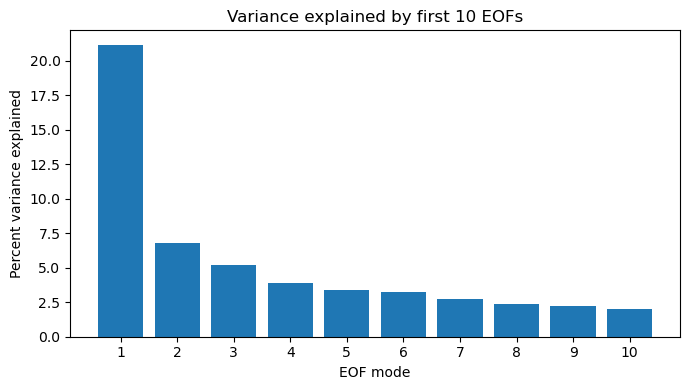

In [ ]:
# choose up the first 10
n = min(10, varfrac.shape[0])
pct = varfrac[:n] * 100.0


fig, ax = plt.subplots(figsize=(7,4))
ax.bar(range(1, n+1), pct)
ax.set_xlabel('EOF mode')
ax.set_ylabel('Percent variance explained')
ax.set_title('Variance explained by first {} EOFs'.format(n))
ax.set_xticks(range(1, n+1))


plt.tight_layout()
plt.show()


In [ ]:
#5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series (which will be "retrended" and "unstandardized") and the "observed" SST time series.

In [46]:
reconstruction = solver.reconstructedField(5)
reconstruction

<xarray.DataArray 'sst' (time: 1020, latitude: 521, longitude: 721)> Size: 2GB
dask.array<divide, shape=(1020, 521, 721), dtype=float32, chunksize=(1020, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2024-12-01
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0
    number     (time) int64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
    expver     (time) <U4 16kB dask.array<chunksize=(1020,), meta=np.ndarray>
    month      (time) int64 8kB dask.array<chunksize=(1020,), meta=np.ndarray>
Attributes:
    long_name:  sst_reconstructed_with_5_EOFs

In [47]:
# To "unstandardize" we need to multiply by the original std and adding the mean
mean = scaler.mean_[0]
std = scaler.scale_[0]
reconstruction = (reconstruction * std) + mean


In [59]:
# Compute Pearson correlation at each grid point between reconstructed and observed SST

sst_for_corr = ds['sst'].rename({"valid_time": "time"})
corr_map = xr.corr(reconstruction, sst_for_corr, dim='time')


In [60]:
print(corr_map)

<xarray.DataArray 'sst' (latitude: 521, longitude: 721)> Size: 3MB
dask.array<truediv, shape=(521, 721), dtype=float64, chunksize=(30, 30), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 4kB 65.0 64.75 64.5 ... -64.5 -64.75 -65.0
  * longitude  (longitude) float64 6kB 120.0 120.2 120.5 ... 299.5 299.8 300.0


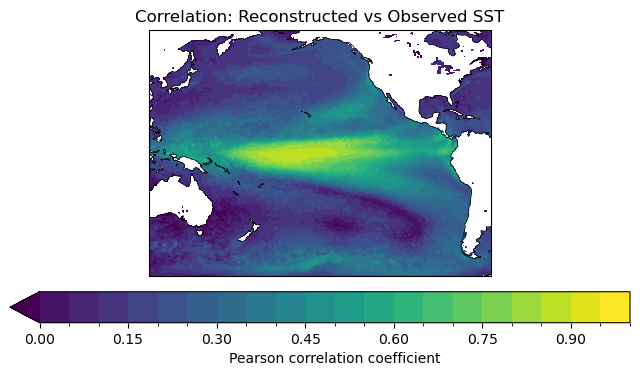

In [62]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)})
clevs = np.linspace(0, 1, 21)
cf = corr_map.plot.contourf(ax=ax, levels=clevs, cmap="viridis", add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_extent([120, 300, -65, 65], crs=ccrs.PlateCarree())
ax.set_title("Correlation: Reconstructed vs Observed SST")
cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Pearson correlation coefficient")
plt.show()

In [ ]:
6#) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting?

In [63]:
# Compute correlation between SST EOF1 (PC time series) and standardized TCWV anomalies at each grid point
sst_pc1 = pc1[:, 0]  # first principal component (time series)
tcwv_std = z['tcwv'].rename({'valid_time': 'time'})  # standardized, detrended, deseasonalized TCWV
corr_tcwv = xr.corr(tcwv_std, sst_pc1, dim='time')


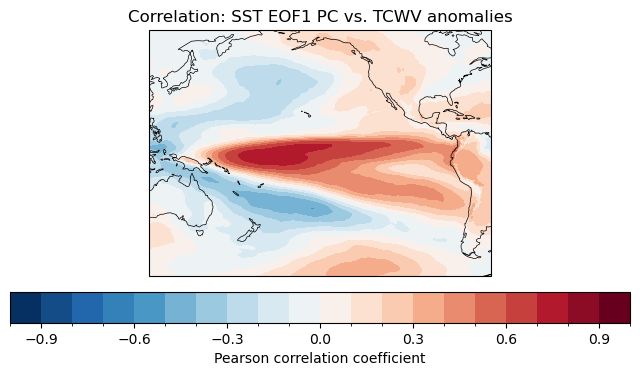

In [65]:
fig, ax = plt.subplots(figsize=(8, 4), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=190)})
clevs = np.linspace(-1, 1, 21)
cf = corr_tcwv.plot.contourf(ax=ax, levels=clevs, cmap='RdBu_r', add_colorbar=False, transform=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.set_title("Correlation: SST EOF1 PC vs. TCWV anomalies")
cbar = fig.colorbar(cf, ax=ax, orientation='horizontal', pad=0.05)
cbar.set_label("Pearson correlation coefficient")
plt.show()

The most interesting pattern I can see is that there is a high correlation between sea surface temperature eof1 (that explains the highest variance of the data) and tcwv where the temperatures are higher. 